In [26]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report
# use to ignore the warning, not a good pratice
import warnings
warnings.filterwarnings("ignore")

In [4]:
#loading the data from the file
file_name = 'german.data'
credit_data = pd.read_csv(file_name, header=None, delimiter=r"\s+")
credit_data.columns = ['account_check_status', 'duration_in_month',
       'credit_history', 'purpose', 'credit_amount', 'savings',
       'present_emp_since', 'installment_as_income_perc',
       'personal_status_sex', 'other_debtors', 'present_res_since', 'property',
       'age', 'other_installment_plans', 'housing', 'credits_this_bank', 'job',
       'people_under_maintenance', 'telephone', 'foreign_worker','class']
cols = list(credit_data.columns)

In [5]:
#seperate the columns in to categorical and continous variables
cols_new_cat = []#cateogrical
cols_new_con = []#continious
for i in cols[:-1]:
    #print(i,":",credit_data[i].dtypes)    
    if credit_data[i].dtypes == 'object':
        cols_new_cat.append(i)   
    else:
        cols_new_con.append(i)   
        
#print(cols_new_cat)
#print(cols_new_con)

In [7]:
#create the dummy columns for the categorical variables
df_new = pd.DataFrame()
for col in cols_new_cat:
    pfx = col
    dummy_temp = pd.get_dummies(credit_data[col], prefix=pfx)    
    df_new = pd.concat([df_new,dummy_temp],axis=1,sort=False)

df_new = pd.concat([df_new,credit_data[cols_new_con],credit_data['class']],axis=1,sort=False)
    
df_new.shape

(1000, 62)

In [8]:
#spliting into Test & Training set
x_train, x_test, y_train, y_test = train_test_split(df_new.drop(['class'],axis=1),df_new['class'],
                                                   train_size=0.7, random_state=0)

In [9]:
#initilize the RF model
'''
Number of trees is 1000
Criterion of slitting is gini
Maximum depth each decision tree can grow is 100
Minimum observations required at each not to be eligible for splitting is 3
Minimum number of observations in tree node should be 2
'''
model = RandomForestClassifier(n_estimators=1000, 
                               criterion='gini',
                               max_depth=100,
                               min_samples_split=3,
                               min_samples_leaf=2)

In [10]:
model.fit(x_train,y_train)

print('RF Train Confusion Matrix\n',
     pd.crosstab(y_train, model.predict(x_train),
                rownames=["Actual"],
                colnames=['Predicted']))

print('\nRF Train Accuracy\n',
     round(accuracy_score(y_train,model.predict(x_train)),3))

print('\nRF Test Confusion Matrix\n',
     pd.crosstab(y_test, model.predict(x_test),
                rownames=["Actual"],
                colnames=['Predicted']))

print('\nRF Test Accuracy\n',
     round(accuracy_score(y_test, model.predict(x_test)),3))

RF Train Confusion Matrix
 Predicted    1    2
Actual             
1          486    0
2           25  189

RF Train Accuracy
 0.964

RF Test Confusion Matrix
 Predicted    1   2
Actual            
1          194  20
2           46  40

RF Test Accuracy
 0.78


In [11]:
# implement Grid-Search on RF to get the list of best parameters
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [83]:
#create pipeline to iterate over the selected parameter combination
pipeline = Pipeline([('clf',RandomForestClassifier(criterion='gini'))])
parameters = {'clf__n_estimators':(1000,2000),
             'clf__max_depth':(200,300),
             'clf__min_samples_split':(2,3),
             'clf__min_samples_leaf':(1,2)}
'''
parameters = {'clf__n_estimators':(1000,2000,3000),
             'clf__max_depth':(100,200,300),
             'clf__min_samples_split':(2,3),
             'clf__min_samples_leaf':(1,2)}
'''             

"\nparameters = {'clf__n_estimators':(1000,2000,3000),\n             'clf__max_depth':(100,200,300),\n             'clf__min_samples_split':(2,3),\n             'clf__min_samples_leaf':(1,2)}\n"

In [84]:
grid_search = GridSearchCV(pipeline, parameters,n_jobs=1,cv=5,verbose=1,scoring='accuracy')
grid_search.fit(x_train,y_train)
print('Best Training score: %0.3f' %grid_search.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  3.4min finished


Best Training score: 0.776


In [19]:
print('Best parameter set:')
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print('\t%s: %f'%(param_name,best_parameters[param_name]))

Best parameter set:
	clf__max_depth: 300.000000
	clf__min_samples_leaf: 2.000000
	clf__min_samples_split: 2.000000
	clf__n_estimators: 2000.000000


In [22]:
# validation using the test set
y_pred = grid_search.predict(x_test)
print('Testing Accuracy:',round(accuracy_score(y_test,y_pred),4))
print('Complete report of Testing')
print(classification_report(y_test,y_pred))
print('RF-Grid Search Confusion Matrix')
print(pd.crosstab(y_test,y_pred,rownames=['Actual'],colnames=['Predictions']))

Testing Accuracy: 0.78
Complete report of Testing
             precision    recall  f1-score   support

          1       0.81      0.91      0.86       214
          2       0.67      0.45      0.54        86

avg / total       0.77      0.78      0.77       300

RF-Grid Search Confusion Matrix
Predictions    1   2
Actual              
1            195  19
2             47  39


In [29]:
# Get the variable importance values
import matplotlib.pyplot as plt
model =  RandomForestClassifier(n_estimators=1000,criterion='gini',max_depth=300,min_samples_split=3,min_samples_leaf=1)
model.fit(x_train,y_train)

imp = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],axis=0)
indices = np.argsort(imp)[::-1]
colnames=list(x_train.columns)

In [47]:
x_train.shape

(700, 61)

In [49]:
print('Feature ranking')
for f in range(x_train.shape[1]):
      print('Feature',indices[f],',',colnames[f], round(imp[indices[f]],4))

Feature ranking
Feature 55 , account_check_status_A11 0.102
Feature 54 , account_check_status_A12 0.0805
Feature 58 , account_check_status_A13 0.0733
Feature 3 , account_check_status_A14 0.0511
Feature 0 , credit_history_A30 0.0461
Feature 57 , credit_history_A31 0.0317
Feature 56 , credit_history_A32 0.0315
Feature 8 , credit_history_A33 0.0194
Feature 36 , credit_history_A34 0.0183
Feature 25 , purpose_A40 0.0181
Feature 59 , purpose_A41 0.0178
Feature 19 , purpose_A410 0.0168
Feature 9 , purpose_A42 0.0165
Feature 1 , purpose_A43 0.0164
Feature 4 , purpose_A44 0.0149
Feature 42 , purpose_A45 0.0147
Feature 23 , purpose_A46 0.0145
Feature 5 , purpose_A48 0.0142
Feature 48 , purpose_A49 0.0141
Feature 30 , savings_A61 0.0141
Feature 26 , savings_A62 0.0137
Feature 44 , savings_A63 0.0136
Feature 38 , savings_A64 0.0134
Feature 31 , savings_A65 0.0133
Feature 51 , present_emp_since_A71 0.0132
Feature 50 , present_emp_since_A72 0.0132
Feature 28 , present_emp_since_A73 0.0129
Feature 6 

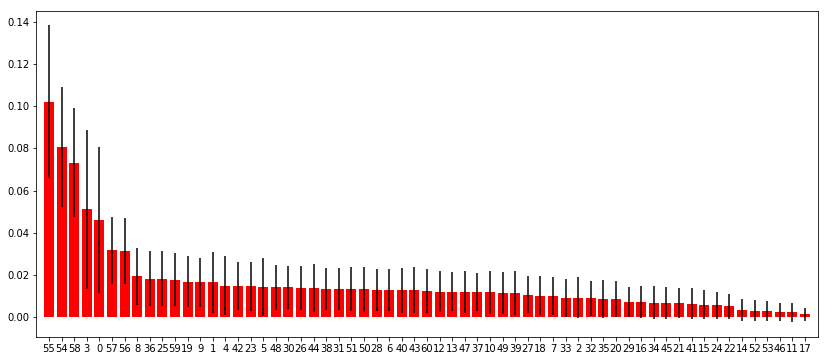

In [69]:
plt.figure(figsize=(14,6))
plt.bar(range(x_train.shape[1]),imp[indices],color='r',yerr=std[indices],align='center')
plt.xticks(range(x_train.shape[1]),indices)
plt.xlim([-1,x_train.shape[1]])
plt.show()